# Reinforcement Learning with Function Approximation

In [0]:
!pip install torch==1.2.0 torchvision pyvirtualdisplay matplotlib seaborn pandas numpy pathlib gym

In [0]:
!pip install pyvirtualdisplay

In [0]:
!apt-get install x11-utils

In [0]:
!sudo apt-get install xvfb
!git clone https://github.com/rlgammazero/mvarl_hands_on.git > /dev/null 2>&1
!cd mvarl_hands_on && git pull origin master > /dev/null 2>&1

In [0]:

import torch
import torch.nn as nn
import torch.nn.functional as F 
from torch import optim

import pandas as pd
import itertools
import seaborn as sns


import numpy as np
import math

from pathlib import Path
import base64

import gym
from gym.wrappers import Monitor
from pprint import pprint
from pyvirtualdisplay import Display
from IPython import display as ipythondisplay
from IPython.display import clear_output

# The following code is will be used to visualize the environments.

def show_video(directory):
    html = []
    for mp4 in Path(directory).glob("*.mp4"):
        video_b64 = base64.b64encode(mp4.read_bytes())
        html.append('''<video alt="{}" autoplay 
                      loop controls style="height: 400px;">
                      <source src="data:video/mp4;base64,{}" type="video/mp4" />
                 </video>'''.format(mp4, video_b64.decode('ascii')))
    ipythondisplay.display(ipythondisplay.HTML(data="<br>".join(html)))
    
display = Display(visible=0, size=(1400, 900))
display.start();

def make_seed(seed):
    np.random.seed(seed=seed)
    torch.manual_seed(seed=seed)

PyTorch is a Python package that provides two high-level features:
- Tensor computation (like NumPy) with strong GPU acceleration
- Deep neural networks built on a tape-based autograd system

At a granular level, PyTorch is a library that consists of the following components:

| Component | Description |
| ---- | --- |
| [**torch**](https://pytorch.org/docs/stable/torch.html) | a Tensor library like NumPy, with strong GPU support |
| [**torch.autograd**](https://pytorch.org/docs/stable/autograd.html) | a tape-based automatic differentiation library that supports all differentiable Tensor operations in torch |
| [**torch.jit**](https://pytorch.org/docs/stable/jit.html) | a compilation stack (TorchScript) to create serializable and optimizable models from PyTorch code  |
| [**torch.nn**](https://pytorch.org/docs/stable/nn.html) | a neural networks library deeply integrated with autograd designed for maximum flexibility |
| [**torch.multiprocessing**](https://pytorch.org/docs/stable/multiprocessing.html) | Python multiprocessing, but with magical memory sharing of torch Tensors across processes. Useful for data loading and Hogwild training |
| [**torch.utils**](https://pytorch.org/docs/stable/data.html) | DataLoader and other utility functions for convenience |


**Tutorials on PyTorch:** https://pytorch.org/tutorials/


## OpenAI gym
We will consider environments provided by OpenAI gym
This library provides a large number of environments to test RL algorithm.

We will focus on the **CartPole-v1** environment in this lab but we encourage you to also test your code on:
* **Acrobot-v1**
* **MountainCar-v0**

| Env Info          	| CartPole-v1 	| Acrobot-v1                	| MountainCar-v0 	|
|-------------------	|-------------	|---------------------------	|----------------	|
| **Observation Space** 	| Box(4)      	| Box(6)                    	| Box(2)         	|
| **Action Space**      	| Discrete(2) 	| Discrete(3)               	| Discrete(3)    	|
| **Rewards**           	| 1 per step  	| -1 if not terminal else 0 	| -1 per step    	|

A gym environment is loaded with the command `env = gym.make(env_id)`. Once the environment is created, you need to reset it with `observation = env.reset()` and then you can interact with it using the method step: `observation, reward, done, info = env.step(action)`.

In [0]:
# We load CartPole-v1
env = gym.make('CartPole-v1')
# We wrap it in order to save our experiment on a file.
env = Monitor(env, "./gym-results", force=True)

In [0]:
done = False
obs = env.reset()
while not done:
    action = env.action_space.sample()
    obs, reward, done, info = env.step(action)
env.close()
show_video("./gym-results")

## REINFORCE

**Q1: Implement the REINFORCE algorithm**

The code is splitted in two parts:
* The Model class defines the architecture of our neural network which takes as input the current state and returns the policy,
* The Agent class is responsible for the training and evaluation procedure. You will need to code the method `optimize_model`.

In [0]:
class Model(nn.Module):
    def __init__(self, dim_observation, n_actions):
        super(Model, self).__init__()
        
        self.n_actions = n_actions
        self.dim_observation = dim_observation
        
        self.net = nn.Sequential(
            nn.Linear(in_features=self.dim_observation, out_features=16),
            nn.ReLU(),
            nn.Linear(in_features=16, out_features=8),
            nn.ReLU(),
            nn.Linear(in_features=8, out_features=self.n_actions),
            nn.Softmax(dim=0)
        )
        
    def forward(self, state):
        return self.net(state)
    
    def select_action(self, state):
        action = torch.multinomial(self.forward(state), 1)
        return action

Create the model based on the properties of the MDP you want to solve

In [0]:
env_id = 'CartPole-v1'
env = gym.make(env_id)
model = Model(env.observation_space.shape[0], env.action_space.n)
print(f'The model we created correspond to:\n{model}')

The model we created correspond to:
Model(
  (net): Sequential(
    (0): Linear(in_features=4, out_features=16, bias=True)
    (1): ReLU()
    (2): Linear(in_features=16, out_features=8, bias=True)
    (3): ReLU()
    (4): Linear(in_features=8, out_features=2, bias=True)
    (5): Softmax(dim=0)
  )
)


We provide a base agent that you will need to extend in the next cell with your implementation of `optimize_model`.

In [0]:
class BaseAgent:
    
    def __init__(self, config):
        self.config = config
        self.env = gym.make(config['env_id'])
        make_seed(config['seed'])
        self.env.seed(config['seed'])
        self.model = Model(self.env.observation_space.shape[0], self.env.action_space.n)
        self.gamma = config['gamma']
        
        # the optimizer used by PyTorch (Stochastic Gradient, Adagrad, Adam, etc.)
        self.optimizer = torch.optim.Adam(self.model.net.parameters(), lr=config['learning_rate'])
        self.monitor_env = Monitor(env, "./gym-results", force=True, video_callable=lambda episode: True)
    
    # Method to implement
    def _compute_returns(self, rewards):
      cum_rew = np.zeros((len(rewards),1))
      for k in range(len(rewards)):
        cum_rew[k] = sum(rewards[i]*self.gamma**(i-k) for i in range(k,len(rewards)))
      return cum_rew
    
    # Method to implement
    def optimize_model(self, n_trajectories):
      loss = 0
      reward_trajectories = []
      for i in range(n_trajectories):
        rewards = []
        done = False
        obs = torch.tensor(self.env.reset(), dtype=torch.float)
        actions = []
        states = []
        while not done:
            action = self.model.select_action(obs).item()
            actions.append(action)
            states.append(obs)
            obs, reward, done, info = self.env.step(action)
            obs = torch.tensor(obs, dtype=torch.float)
            rewards.append(reward)
        cumulative_rewards = self._compute_returns(np.array(rewards))
        reward_trajectories.append(cumulative_rewards[0])

        s = 0
        for t in range(len(states)):
          s += torch.log(self.model.forward(states[t])[actions[t]])*cumulative_rewards[t]
        loss += s
      loss /= n_trajectories
      loss = -loss

      reward_trajectories = np.array(rewards_trajectories)
      return reward_trajectories
 
    def train(self, n_trajectories, n_update):
        """Training method

        Parameters
        ----------
        n_trajectories : int
            The number of trajectories used to approximate the expected gradient
        n_update : int
            The number of gradient updates
            
        """
        
        rewards = []
        for episode in range(n_update):
            rewards.append(self.optimize_model(n_trajectories))
            print(f'Episode {episode + 1}/{n_update}: rewards {round(rewards[-1].mean(), 2)} +/- {round(rewards[-1].std(), 2)}')
        
        # Plotting
        r = pd.DataFrame((itertools.chain(*(itertools.product([i], rewards[i]) for i in range(len(rewards))))), columns=['Epoch', 'Reward'])
        sns.lineplot(x="Epoch", y="Reward", data=r, ci='sd');
        
    def evaluate(self, render=False):
        """Evaluate the agent on a single trajectory            
        """
        with torch.no_grad():
            observation = self.monitor_env.reset()
            observation = torch.tensor(observation, dtype=torch.float)
            reward_episode = 0
            done = False
                
            while not done:
                action = self.model.select_action(observation)
                observation, reward, done, info = self.monitor_env.step(int(action))
                observation = torch.tensor(observation, dtype=torch.float)
                reward_episode += reward
            
            self.monitor_env.close()
            if render:
                show_video("./gym-results")
                print(f'Reward: {reward_episode}')
            print(f'Reward: {reward_episode}')

Finally you can implement your agent

In [0]:
class REINFORCE(BaseAgent):
    
    def _compute_returns(self, rewards):
      '''cum_rew = np.zeros((len(rewards),1))
      for k in range(len(rewards)):
        cum_rew[k] = sum(rewards[i]*self.gamma**(i-k) for i in range(k,len(rewards)))
      return cum_rew'''
      n = len(rewards)
      for i in range(n):
          for j in range(i,n):
              rewards[i] += rewards[j] * gamma**(j-i)
      return rewards

    
        
    def optimize_model(self, n_trajectories):       
      loss = 0
      rewards_trajectories = []
      for i in range(n_trajectories):
 
        cumulative_rewards = self._compute_returns(np.array(rewards))
        rewards_trajectories.append(cumulative_rewards[0])
        
        s = 0       rewards = []
        done = False
        obs = torch.tensor(self.env.reset(), dtype=torch.float)
        actions = []
        states = []
        while not done:
            action = self.model.select_action(obs).item()
            actions.append(action)
            states.append(obs)
            obs, reward, done, info = self.env.step(action)
            obs = torch.tensor(obs, dtype=torch.float)
            rewards.append(reward)
        for t in range(len(states)):
          s += torch.log(self.model.forward(states[t]))[actions[t]]*cumulative_rewards[t]
        loss += s
      loss /= n_trajectories
      loss = -loss

      reward_trajectories = np.array(rewards_trajectories)
        # Discard previous gradients
      self.optimizer.zero_grad()
        # Compute the gradient 
      loss.backward()
        # Do the gradient descent step
      self.optimizer.step()
      return reward_trajectories
    

In [0]:
env_id = 'CartPole-v1'
learning_rate = 0.01
gamma = 1 
seed = 1235

config = {
    'env_id': env_id,
    'learning_rate': learning_rate,
    'seed': seed,
    'gamma': gamma
}

print("Current config is:")
pprint(config)


Current config is:
{'env_id': 'CartPole-v1', 'gamma': 1, 'learning_rate': 0.01, 'seed': 1235}


Episode 1/50: rewards 17.9 +/- 6.2
Episode 2/50: rewards 24.4 +/- 10.22
Episode 3/50: rewards 22.78 +/- 10.9
Episode 4/50: rewards 24.44 +/- 12.22
Episode 5/50: rewards 24.16 +/- 15.84
Episode 6/50: rewards 25.36 +/- 13.01
Episode 7/50: rewards 25.62 +/- 14.78
Episode 8/50: rewards 25.92 +/- 14.38
Episode 9/50: rewards 27.6 +/- 15.79
Episode 10/50: rewards 26.88 +/- 14.47
Episode 11/50: rewards 29.66 +/- 14.07
Episode 12/50: rewards 30.34 +/- 15.0
Episode 13/50: rewards 27.2 +/- 12.48
Episode 14/50: rewards 28.4 +/- 15.38
Episode 15/50: rewards 29.06 +/- 14.48
Episode 16/50: rewards 39.2 +/- 25.07
Episode 17/50: rewards 37.14 +/- 21.44
Episode 18/50: rewards 34.34 +/- 15.92
Episode 19/50: rewards 34.32 +/- 17.95
Episode 20/50: rewards 41.9 +/- 22.76
Episode 21/50: rewards 35.26 +/- 18.29
Episode 22/50: rewards 43.72 +/- 15.98
Episode 23/50: rewards 41.36 +/- 28.02
Episode 24/50: rewards 46.16 +/- 23.87
Episode 25/50: rewards 42.16 +/- 21.9
Episode 26/50: rewards 54.6 +/- 29.76
Episode 

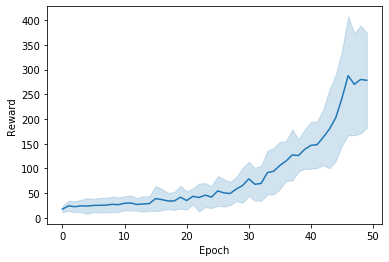

In [0]:
agent = REINFORCE(config)
agent.train(n_trajectories=50, n_update=50)

Evaluate the agent over multiple episodes

In [0]:
agent.evaluate()

500.0

## Policy Evaluation as Supervised Learning

**Q2: Implement batched gradient algorithm**

Define network for Q-function (ValueNetwork) and policy (ActorNetwork)


In [0]:
class ValueNetwork(nn.Module):

    def __init__(self, input_size, hidden_size, output_size):
        super(ValueNetwork, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        out = F.relu(self.fc1(x))
        out = F.relu(self.fc2(out))
        out = self.fc3(out)
        return out
    
    def predict(self, x):
        return self(x).detach().numpy()[0]

In [0]:
class ActorNetwork(nn.Module):

    def __init__(self, input_size, hidden_size, action_size):
        super(ActorNetwork, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, action_size)

    def forward(self, x):
        out = F.relu(self.fc1(x))
        out = F.relu(self.fc2(out))
        out = F.softmax(self.fc3(out), dim=-1)
        return out
    
    def select_action(self, x):
        return torch.multinomial(self(x), 1).detach().numpy()

Implement your (batched) gradient algorithm



In [0]:
class EvalAgent:

    def __init__(self, config, policy):
        self.config = config
        self.env = gym.make(config['env_id'])
        make_seed(config['seed'])
        self.env.seed(config['seed'])
        self.monitor_env = Monitor(self.env, "./gym-results", force=True, video_callable=lambda episode: True)
        self.gamma = config['gamma']
        self.policy = policy

        # Our network
        self.value_network = ValueNetwork(self.env.observation_space.shape[0], 16, 1)

        # optimizers
        self.value_network_optimizer = optim.RMSprop(self.value_network.parameters(), 
                                                   lr=config['value_network']['learning_rate'])
        
    
    def _returns_advantages(self, rewards, dones, next_value):
      """Returns the cumulative discounted rewards at each time step

        Parameters
        ----------
        rewards : array
            An array of shape (batch_size,) containing the rewards given by the env
        dones : array
            An array of shape (batch_size,) containing the done bool indicator given by the env
        next_value : float
            The value of the next state given by the value network

        Returns
        -------
        returns : array
            The cumulative discounted rewards
        """
      batch_size = len(rewards)
      cum_reward = []
  
      for k in range(batch_size):

        reward_t = []
        done = dones[k]
        obs = torch.tensor(self.env.reset(), dtype=torch.float)
        actions = []
        states = []
        while not done:
            obs = torch.tensor(obs, dtype=torch.float)
            action = self.policy.select_action(obs).item()
            actions.append(action)
            states.append(obs)
            obs, reward, done, info = self.env.step(action)
            obs = torch.tensor(obs, dtype=torch.float)
            reward_t.append(reward)

        #cum_rew = np.zeros((len(reward_t),1))
        if k != batch_size - 1:
          for j in range(len(reward_t)):
            cum_reward.append(sum(reward_t[i]*self.gamma**(i-j) for i in range(j,len(reward_t))))
        else:
          reward_t.append(next_value) 
          for j in range(len(reward_t)):
            cum_reward.append(sum(reward_t[i]*self.gamma**(i-j) for i in range(j,len(reward_t))))

        #cum_reward[k] = np.sum(reward_t[i]*self.gamma**i for i in range(len(reward_t)))
        #cum_reward[k] = cum_reward[k] + next_value*self.gamma**(len(reward_t))
      return np.array(cum_reward)
    
    
    def optimize_model(self, observations, actions, returns):
        """Perform a gradient update using provided transitions

        Parameters
        ----------
        observations : array
            The observations
        actions : array
            The actions
        returns : array
            The returns from each state

        Returns
        -------
        loss_value: int
            The loss value
        """
        actions = F.one_hot(torch.tensor(actions), self.env.action_space.n)
        returns = torch.tensor(returns[:, None], dtype=torch.float)
        observations = torch.tensor(observations, dtype=torch.float)

        vstar = self.value_network(observations)
        v = vstar.clone()
        size = returns.size()[0]//vstar.size()[0]
        rest = returns.size()[0]%vstar.size()[0]
        for j in range(size-1):
          v = torch.cat((v, vstar), 0)
        v = torch.cat((v, vstar[:rest]), 0)

        self.value_network_optimizer.zero_grad()

        output = F.mse_loss(returns,v)
        output.backward()
        self.value_network_optimizer.step()

        return output
    
    def training_batch(self, epochs, batch_size):
        """Perform a training by batch

        Parameters
        ----------
        epochs : int
            Number of epochs
        batch_size : int
            The size of a batch
        """
        episode_count = 0
        actions = np.empty((batch_size,), dtype=np.int)
        dones = np.empty((batch_size,), dtype=np.bool)
        rewards, values = np.empty((2, batch_size), dtype=np.float)
        observations = np.empty((batch_size,) + self.env.observation_space.shape, dtype=np.float)
        observation = self.env.reset()
        mse_test = []

        for epoch in range(epochs):
            # Lets collect one batch
            for i in range(batch_size):
                observations[i] = observation
                observation = torch.tensor(observation, dtype=torch.float)
                #values[i] =  #TO DO
                actions[i] = self.policy.select_action(observation).item()

                observation, reward, done, info = self.env.step(actions[i])
                observation = torch.tensor(observation, dtype=torch.float)
                rewards[i] = reward

                # step

                if dones[i]:
                    observation = self.env.reset()

            # If our epiosde didn't end on the last step we need to compute the value for the last state
            if dones[-1]:
                next_value = 0
            else:
                next_value = self.value_network(observations)

            # Update episode_count
            episode_count += sum(dones)

            # Compute returns
            returns = self._returns_advantages(rewards, dones, next_value)

            # Learning step !
            self.optimize_model(observations, actions, returns)

            # Test it every 50 epochs
            if epoch % 25 == 0 or epoch == epochs - 1:
                L = []
                for _ in range(10):
                    obs_states, y_mc = self.evaluate()
                    y_hat = self.value_network.predict(torch.tensor(obs_states, dtype=torch.float))
                    err = y_mc - y_hat
                    mse = np.mean(err**2)
                    L.append(mse.item())
                mse_test.append(L)
                print(f'Epoch {epoch}/{epochs}: MSE: {np.mean(mse)}')

                observation = self.env.reset()

        # Plotting
        r = pd.DataFrame((itertools.chain(*(itertools.product([i], mse_test[i]) for i in range(len(mse_test))))), columns=['Epoch', 'MSE'])
        sns.lineplot(x="Epoch", y="MSE", data=r, ci='sd');

        print(f'The trainnig was done over a total of {episode_count} episodes')

    def evaluate(self, render=False):
        """Returns the observations and the estimated V-function (using first visit Monte-Carlo)

        Parameters
        ----------
        rewards : array
            An array of shape (batch_size,) containing the rewards given by the env
        dones : array
            An array of shape (batch_size,) containing the done bool indicator given by the env
        values : array
            An array of shape (batch_size,) containing the values given by the value network
        next_value : float
            The value of the next state given by the value network

        Returns
        -------
        states : array
            Observations
        returns : array
            The estimate value function of each state
        """
        env = self.monitor_env if render else self.env
        observation = env.reset()
        states = [observation.copy()]
        rewards= []
        observation = torch.tensor(observation, dtype=torch.float)
        done = False
        steps = 0

        while not done:
            observation = torch.tensor(observation, dtype=torch.float)
            action = self.policy.select_action(observation).item()
            observation, reward, done, info = env.step(int(action))
            for i in range(steps):
                rewards[i] = rewards[i] + math.pow(self.gamma, steps-i)*reward
            rewards.append(reward)
            if not done:
                states.append(observation.copy())
            observation = torch.tensor(observation, dtype=torch.float)
            steps += 1

        env.close()
        if render:
            show_video("./gym-results")
            print(f'Reward: {reward_episode}')
        states = np.array(states).reshape(-1, self.env.observation_space.shape[0])
        returns = np.array(rewards).reshape(-1,1)
        return states, returns

Define configuration

In [0]:
env_id = 'CartPole-v1'
value_learning_rate = 0.001
gamma = 0.99
seed = 1

config_td = {
    'env_id': env_id,
    'gamma': gamma,
    'seed': seed,
    'value_network': {'learning_rate': value_learning_rate, 'reference': './CartPole_value.pt'}
}

print("Current config_td is:")
pprint(config_td)


Current config_td is:
{'env_id': 'CartPole-v1',
 'gamma': 0.99,
 'seed': 1,
 'value_network': {'learning_rate': 0.001, 'reference': './CartPole_value.pt'}}


Create policy

In [0]:
env = gym.make(config_td['env_id'])
policy = ActorNetwork(env.observation_space.shape[0], 16, env.action_space.n)
policy.load_state_dict(torch.load('./mvarl_hands_on/data/CartPole_actor.pt'))
state = torch.tensor(np.array(env.reset(), dtype=np.float32))
print("pi(state) = ", policy.select_action(state))
del env

pi(state) =  [1]


Run agent

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:149: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:48: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:227: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch 0/1000: MSE: 7039.873233243567
Epoch 25/1000: MSE: 6978.797821880336
Epoch 50/1000: MSE: 6190.444417731068
Epoch 75/1000: MSE: 6829.005713077666
Epoch 100/1000: MSE: 6736.166599857273
Epoch 125/1000: MSE: 6633.46564850947
Epoch 150/1000: MSE: 1210.9073466660532
Epoch 175/1000: MSE: 6374.6200942592
Epoch 200/1000: MSE: 5737.746450752736
Epoch 225/1000: MSE: 3153.897945068654
Epoch 250/1000: MSE: 5886.391339930484
Epoch 275/1000: MSE: 5711.305221591132
Epoch 300/1000: MSE: 5524.012318058802
Epoch 325/1000: MSE: 5320.984007865999
Epoch 350/1000: MSE: 5095.217595504979
Epoch 375/1000: MSE: 4891.207396693561
Epoch 400/1000: MSE: 3534.8269275712396
Epoch 425/1000: MSE: 4412.106076807212
Epoch 450/1000: MSE: 4160.217507516543
Epoch 475/1000: MSE: 3919.2479088111977
Epoch 500/1000: MSE: 3450.92653554999
Epoch 525/1000: MSE: 3385.909150575518
Epoch 550/1000: MSE: 3154.0429134951737
Epoch 575/1000: MSE: 2709.347351611753
Epoch 600/1000: MSE: 2703.6654673119565
Epoch 625/1000: MSE: 2455.232

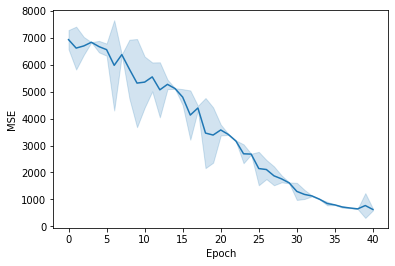

In [0]:
agent = EvalAgent(config=config_td, policy=policy)
agent.training_batch(epochs=1000, batch_size=256)

## Advantage Actor Critic (A2C)
**Q3: Implement the A2C method**

As usual we provide a structure you can use as starting point.



**Note:** try to reuse previous parts of previous code.



Create configuration for A2C

In [0]:
class A2CAgent:

    def __init__(self, config):
        self.config = config
        self.env = gym.make(config['env_id'])
        make_seed(config['seed'])
        self.env.seed(config['seed'])
        self.monitor_env = Monitor(self.env, "./gym-results", force=True, video_callable=lambda episode: True)
        self.gamma = config['gamma']
        
        # Our two networks
        self.value_network = ValueNetwork(self.env.observation_space.shape[0], 16, 1)
        self.actor_network = ActorNetwork(self.env.observation_space.shape[0], 16, self.env.action_space.n)
        
        # Their optimizers
        self.value_network_optimizer = optim.RMSprop(self.value_network.parameters(), lr=config['value_network']['learning_rate'])
        self.actor_network_optimizer = optim.RMSprop(self.actor_network.parameters(), lr=config['actor_network']['learning_rate'])
        
    # Hint: use it during training_batch
    def _returns_advantages(self, rewards, dones, values, next_value):
      returns = np.zeros(len(rewards))
      val = next_value
      for i in range(1, len(rewards)+1):
          last = 1-dones[-i]  
          val = rewards[-i] + self.gamma * last * val
          returns[-i] = val
      advantages = returns - values
      return returns, advantages

    def training_batch(self, epochs, batch_size):
      """Perform a training by batch

        Parameters
        ----------
        epochs : int
            Number of epochs
        batch_size : int
            The size of a batch
      """
      episode_count = 0
      actions = np.empty((batch_size,), dtype=np.int)
      dones = np.empty((batch_size,), dtype=np.bool)
      rewards, values = np.empty((2, batch_size), dtype=np.float)
      observations = np.empty((batch_size,) + self.env.observation_space.shape, dtype=np.float)
      observation = self.env.reset()
      rewards_test = []

      for epoch in range(epochs):
          # Lets collect one batch
          for i in range(batch_size):
            observations[i] = observation
            observation = torch.tensor(observation, dtype=torch.float)
            values[i] = self.value_network(torch.tensor(observation, dtype=torch.float))
            #values[i] =  self.value_network(observations)
            actions[i] =  int(self.actor_network.select_action(observation))
            #actions[i] = self.policy.select_action(observation).item()

            observation, reward, done, info = self.env.step(actions[i])
            observation = torch.tensor(observation, dtype=torch.float)
            rewards[i] = reward
            dones[i] = done
            if dones[i]:
              observation = self.env.reset()
            # If our epiosde didn't end on the last step we need to compute the value for the last state
          if dones[-1]:
            next_value = 0
          else:
            #next_value = self.value_network(observation)
            obs = torch.from_numpy(observations[len(observations)-1]).float()
            next_value = self.value_network.predict(obs)

            # Compute returns and advantages 
          returns, advantages = self._returns_advantages(rewards, dones, values, next_value)
            
            # Update episode_count
          episode_count += sum(dones)


            # Learning step !
          self.optimize_model(observations, actions, returns, dones, advantages)

            # Test it every 50 epochs
          if epoch % 50 == 0 or epoch == epochs - 1:
            rewards_test.append(np.array([self.evaluate() for _ in range(50)]))
            print(f'Epoch {epoch}/{epochs}: Mean rewards: {round(rewards_test[-1].mean(), 2)}, Std: {round(rewards_test[-1].std(), 2)}')

            # Early stopping
            if rewards_test[-1].mean() > 490 and epoch != epochs -1:
                print('Early stopping !')
                break
            observation = self.env.reset()
                    
      # Plotting
      r = pd.DataFrame((itertools.chain(*(itertools.product([i], rewards_test[i]) for i in range(len(rewards_test))))), columns=['Epoch', 'Reward'])
      sns.lineplot(x="Epoch", y="Reward", data=r, ci='sd');
        
      print(f'The trainnig was done over a total of {episode_count} episodes')

    def optimize_model(self, observations, actions, returns, dones, advantages):
        n_t = np.sum(dones)
        init_act = actions
        actions      = F.one_hot(torch.from_numpy(actions), self.env.action_space.n)
        returns      = torch.from_numpy(returns[:, None]).float()
        advantages   = torch.from_numpy(advantages).float()
        observations = torch.from_numpy(observations).float()  
        
        # Critic loss
        pred_values = self.value_network(observations)

        
        critic_loss = -torch.mean(advantages * pred_values)  
        critic_loss.backward()
        
        self.value_network_optimizer.step()
        
        # Actor & Entropy loss
        proba = self.actor_network(observations) 
        loss = 0
        for i in range(len(observations)):
            loss += torch.log(proba[i, init_act[i]])*advantages[i]
        
        loss = -loss
        entropy= 0.001 * torch.sum(torch.log(proba)*proba)
        loss = loss + entropy

        if not dones[-1]:
          n_t += 1
        loss = loss / n_t
        
        loss.backward()
        
        self.actor_network_optimizer.step()
        
        self.value_network_optimizer.zero_grad()
        self.actor_network_optimizer.zero_grad()

        
        return loss.detach().numpy()


    def evaluate(self, render=False):
        env = self.monitor_env if render else self.env
        observation = env.reset()
        observation = torch.tensor(observation, dtype=torch.float)
        reward_episode = 0
        done = False

        while not done:
            policy = self.actor_network(observation)
            action = torch.multinomial(policy, 1)
            observation, reward, done, info = env.step(int(action))
            observation = torch.tensor(observation, dtype=torch.float)
            reward_episode += reward
            
        env.close()
        if render:
            show_video("./gym-results")
            print(f'Reward: {reward_episode}')
        return reward_episode

In [0]:
env_id = 'CartPole-v1'
value_learning_rate = 0.001
actor_learning_rate = 0.001
gamma = 0.99
entropy = 1
seed = 1

config_a2c = {
    'env_id': env_id,
    'gamma': gamma,
    'seed': seed,
    'value_network': {'learning_rate': value_learning_rate},
    'actor_network': {'learning_rate': actor_learning_rate},
    'entropy': entropy
}

print("Current config_a2c is:")
print(config_a2c)

Current config_a2c is:
{'env_id': 'CartPole-v1', 'gamma': 0.99, 'seed': 1, 'value_network': {'learning_rate': 0.001}, 'actor_network': {'learning_rate': 0.001}, 'entropy': 1}


Run the learning agent

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch 0/1000: Mean rewards: 24.86, Std: 16.4
Epoch 50/1000: Mean rewards: 38.04, Std: 21.04
Epoch 100/1000: Mean rewards: 60.54, Std: 31.87
Epoch 150/1000: Mean rewards: 132.44, Std: 66.05
Epoch 200/1000: Mean rewards: 171.58, Std: 96.35
Epoch 250/1000: Mean rewards: 224.58, Std: 96.32
Epoch 300/1000: Mean rewards: 251.52, Std: 105.28
Epoch 350/1000: Mean rewards: 277.5, Std: 103.37
Epoch 400/1000: Mean rewards: 347.22, Std: 132.68
Epoch 450/1000: Mean rewards: 305.56, Std: 113.04
Epoch 500/1000: Mean rewards: 410.74, Std: 110.56
Epoch 550/1000: Mean rewards: 438.0, Std: 106.37
Epoch 600/1000: Mean rewards: 410.12, Std: 94.39
Epoch 650/1000: Mean rewards: 467.04, Std: 66.39
Epoch 700/1000: Mean rewards: 432.78, Std: 95.81
Epoch 750/1000: Mean rewards: 457.14, Std: 93.87
Epoch 800/1000: Mean rewards: 473.5, Std: 69.68
Epoch 850/1000: Mean rewards: 466.26, Std: 80.43
Epoch 900/1000: Mean rewards: 474.94, Std: 71.63
Epoch 950/1000: Mean rewards: 429.84, Std: 111.04
Epoch 999/1000: Mean re

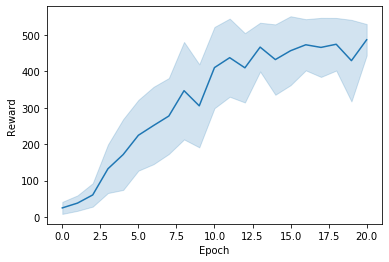

In [0]:
agent = A2CAgent(config_a2c)
rewards = agent.training_batch(1000, 256)

Evaluate the agent over multiple episodes

In [0]:
agent.evaluate()

500.0